In [1]:
# set project path
import sys
from setting import PROJECT_PTH
sys.path.append(str(PROJECT_PTH))

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import pickle
import cv2
from PIL import Image

import torch
import torchvision.transforms as transforms
from torchvision.transforms import functional as F


In [3]:
import random
np.random.seed(2022)
random.seed(2022)
torch.manual_seed(2022)

In [4]:
def readVideo(pth_video):
    videoCapture = cv2.VideoCapture(pth_video)

    fps = videoCapture.get(cv2.CAP_PROP_FPS)
    size = (int(videoCapture.get(cv2.CAP_PROP_FRAME_WIDTH)), 
            int(videoCapture.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    fNUMS = videoCapture.get(cv2.CAP_PROP_FRAME_COUNT)

    frames = list()
    while (videoCapture.isOpened()):
        ret, frame = videoCapture.read()

        if ret: frames.append( cv2.cvtColor(frame,cv2.COLOR_BGR2RGB) )
        else: break
    
    videoCapture.release()
    # print("video size:", size)

    return fps, size, fNUMS, frames

In [5]:
class VideoDataset(torch.utils.data.Dataset):
    def __init__(self, file_list, transform):
        self.transform = transform
        with open(file_list, "rb") as f:
            self.file_list = pickle.load(f)
        

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        pth_video = self.file_list.iloc[idx].file_pth
        label = self.file_list.iloc[idx].cls

        fps, size, fNUMS, frames = readVideo(pth_video)


        seed = np.random.randint(1e9)
        frames_tr = []
        for frame in frames:
            random.seed(seed)
            np.random.seed(seed)
            frame = self.transform(frame)
            frames_tr.append(frame)

        if fNUMS > 80: del frames_tr[80:]
        elif fNUMS < 80: frames_tr = frames_tr+frames_tr[0: 80-fNUMS ]

        if len(frames_tr) > 0: frames_tr = torch.stack(frames_tr)

        return frames_tr, label

**Becareful:**
ToTensor:
- input: (H,W,C), value [0-255]
- output: (C,H,W), value [0.0-1.0]

In [11]:
transform_train = transforms.Compose([
    transforms.ToTensor(), # must have -> getitem():...torch.stack(frames_tr)
    transforms.Resize((128,128))
])
dataset_train = VideoDataset(file_list="20221003001_trainDataFileList.pickle", transform=transform_train)

In [12]:
print(len(dataset_train))

30000


In [13]:
frames, label = dataset_train[12345]

In [14]:
len(frames)

80

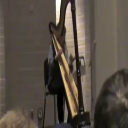

In [15]:
F.to_pil_image(frames[0])

In [16]:
len(frames)

80